# MNIST

In [183]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import seaborn as sn

import numpy as np

import matplotlib.pyplot as plt

In [113]:
mnist = fetch_openml("mnist_784", as_frame=False)

In [114]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [115]:
X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

In [116]:
28 * 28

784

In [117]:
mnist.categories

{'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

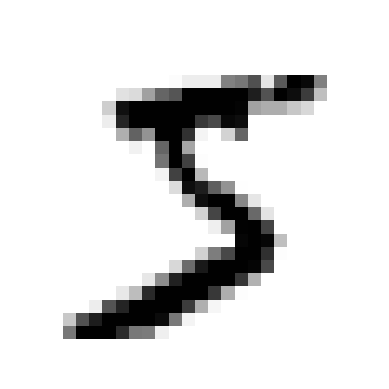

In [118]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [119]:
y[0]

'5'

In [120]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## Training a Binary Classifier

In [121]:
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

y_train_5.shape, y_test_5.shape

((60000,), (10000,))

We use `SGDClassifier` as our first predictor to create a binary model.

In [122]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

`cross_val_score` function evaluate a model using k-fold cross-validation.

In [123]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
cross_val_score(
    sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished


array([0.95035, 0.96035, 0.9604 ])

On all k-fold the accuracy is higher than 95%. Does this metric make any sense? Let's see how a dummy classifier behaves.

In [124]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
cross_val_score(
    dummy_clf, X_train, y_train_5, cv=3, n_jobs=-1, scoring="accuracy", verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


array([0.90965, 0.90965, 0.90965])

Apparently even a dummy classifier performs good in this sample. Is it the problem that simple? Probably not. 
Let's study the data distribution.

In [125]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421]))

The value 5 is a value over 10 different values. So it makes sense that in the distribution we have 1/10 relationship ratio.
With this distribution it makes no sense to use the accuracy as saying that it is not 5 secures you to guess correctly 9/10 times. This is because the data is skewed.

### Confusion Matrix

A Confusion Matrix is a table with rows and columns 
that reports the number of true positives, false negatives, 
false positives, and true negatives. Lets use this visual tool to see how good our models perform.

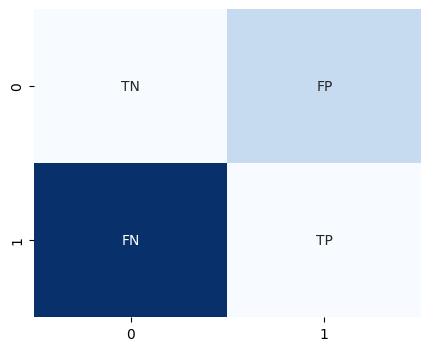

In [126]:
plt.figure(figsize=(5, 4))

labels = ["TN", "FP", "FN", "TP"]
labels = np.asarray(labels).reshape(2, 2)

values = [2, 4, 10, 2]
values = np.asarray(values).reshape(2, 2)

sn.heatmap(values, annot=labels, cmap="Blues", fmt="", cbar=False)

plt.show()

In [127]:
sgd_clf = SGDClassifier(random_state=42)

y_train_predict = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, verbose=2, n_jobs=-1
)
y_train_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished


array([ True, False, False, ...,  True, False, False])

Notice that a model is not fitted after the `cross_*` function is executed, but it makes copy of the model and fit it.

In [128]:
try:
    check_is_fitted(sgd_clf)
except Exception as e:
    print("Model is not fitted yet")

Model is not fitted yet


A possible implementation of `cross_*` could be the following. Notice the copy of the predictor in each iteration.

In [129]:
def _cross_val_score(clf, X, y):
    skfolds = StratifiedKFold(n_splits=3, shuffle=True)

    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(clf)

        X_train_fold = X[train_index]
        X_test_fold = X[test_index]
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_fold, y_train_fold)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))


dummy_clf = DummyClassifier()
_cross_val_score(dummy_clf, X_train, y_train_5)

0.90965
0.90965
0.90965


In the next cell we use the `confusion_matrix` function. Rows represent the actual class and columns the predicted class. Row 0 correspond to non-5 samples and row 1 represents is5 samples.
On the other hand, we got the columns, column 0 represent predicted as non-5 and column 1 represents samples predicted as is5.

In [130]:
cm = confusion_matrix(y_train_5, y_train_predict)
cm

array([[53892,   687],
       [ 1891,  3530]])

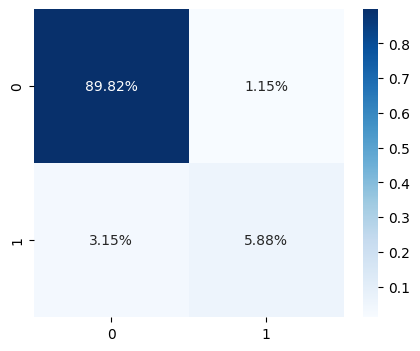

In [131]:
plt.figure(figsize=(5, 4))

sn.heatmap(cm / np.sum(cm), cmap="Blues", annot=True, fmt=".2%")

plt.show()

### Precision and Recall

The accuracy of the positive class is called precision.

$$
precision = \frac{TP}{TP + FP}
$$

In [132]:
precision_score(y_train_5, y_train_predict)

0.8370879772350012

Precision is usually used with another metric called `recall`. This is the ration of positive instances that are correctly detected by the classifier.

$$
recall = \frac{TP}{TP + FN}
$$

In [133]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

As a summary, this model ensures that 83% percents of the time when it detects a 5 is actual a 5 but only captures the 65% of the 5 are found in the dataset.

### Harmonic Mean of Precision and Recall (F1-score)

It is often convinient to combine precision and recall in a single metric. For that we use F1-score. It is usuful when you want to compare different classifiers. F1-score is high when both precision and recall are high. But sometimes, we don't really need that both metrics are high but just one of them, so take than in account.

$$
F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall}
$$

In [134]:
f1_score(y_train_5, y_train_predict)

0.7325171197343847

### Precision and Recall Trade-off

Some models do decision based on a threshold. Therefore, moving that threshold would change the precision and recall of the model. Scikit-Learn does not let us modify that threshold but some models have the `decision_function` method, which returns the score for each instance.

In [135]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In case the theshold is zero. The image `some_digit` is predicted as a five.

In [136]:
threshold = 0
y_scores > threshold

array([ True])

Otherwise, if we change the threshold the prediction change to not five

In [137]:
threshold = 3000
y_scores > threshold

array([False])

Now the question here is to know which is the correct threshold value to choose.

In [138]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, n_jobs=-1, verbose=3, method="decision_function"
)
y_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

With the scores we can use the function `precision_recall_curve` to compute the differents precision and recall per each threshold.

In [139]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [140]:
thresholds[:6]

array([-116288.54262534, -112139.56842955, -110416.13704754,
       -107553.69359446, -106269.70956221, -105238.25249865])

In [141]:
precisions[:6]

array([0.09035   , 0.09035151, 0.09035301, 0.09035452, 0.09035602,
       0.09035753])

In [142]:
recalls[:6]

array([1., 1., 1., 1., 1., 1.])

In [143]:
idx_for_90_precision = (precisions >= 0.9).argmax()
idx_for_90_precision

56032

We want a model that has 90% precision at least, remember that.

In [145]:
threshold_90_precision = thresholds[idx_for_90_precision]
threshold_90_precision

3045.9258227053638

In [79]:
print(
    thresholds[idx_for_90_precision], 
    precisions[idx_for_90_precision], 
    recalls[idx_for_90_precision]
)

3045.9258227053638 0.9002016129032258 0.6589190186312488


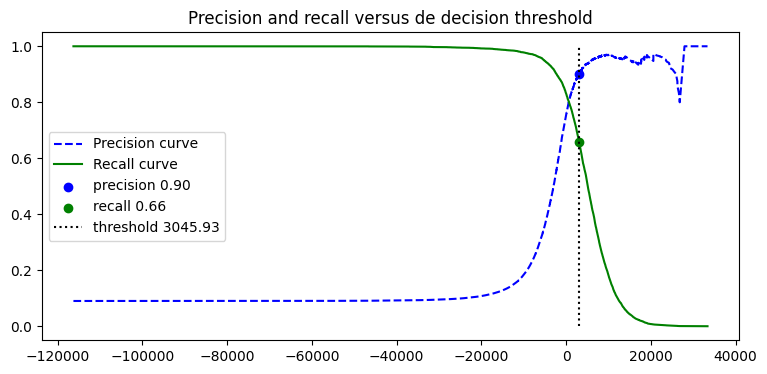

In [148]:
recall = recalls[idx_for_90_precision]
precision = precisions[idx_for_90_precision]
threshold = thresholds[idx_for_90_precision]

plt.figure(figsize=(9, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision curve")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall curve")
plt.scatter(
    threshold,
    precisions[idx_for_90_precision],
    c="blue",
    label=f"precision {precision:.2f}"
)
plt.scatter(
    threshold,
    recalls[idx_for_90_precision],
    c="green",
    label=f"recall {recall:.2f}"
)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label=f"threshold {threshold:.2f}")

plt.title('Precision and recall versus de decision threshold')
plt.legend()
plt.show()

Another way to select a good precision/recall trade-off is to plot precision against recall.

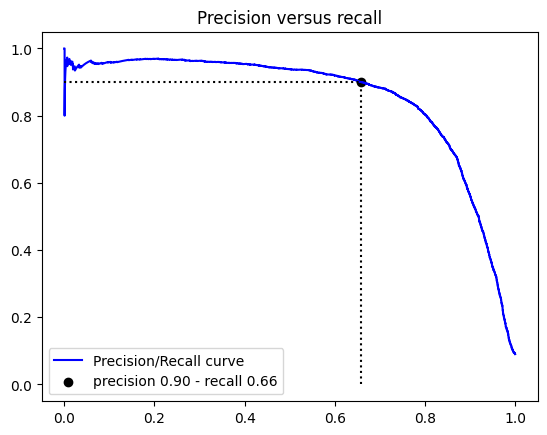

In [149]:
import matplotlib.pyplot as plt

plt.plot(recalls, precisions, "b-", label="Precision/Recall curve")
plt.scatter(
    recalls[idx_for_90_precision],
    precisions[idx_for_90_precision],
    c="black",
    label=f"precision {precision:.2f} - recall {recall:.2f}",
)
plt.hlines(
    precisions[idx_for_90_precision], 0, recalls[idx_for_90_precision], "k", "dotted"
)
plt.vlines(
    recalls[idx_for_90_precision], 0, precisions[idx_for_90_precision], "k", "dotted"
)

plt.title('Precision versus recall')
plt.legend()
plt.show()

Now for make predictions we use the treshold that ensures us a precision of 90%

In [153]:
y_train_pred_90_precision = y_scores > thresholds[idx_for_90_precision]
precision_score(y_train_5, y_train_pred_90_precision)

0.9001764557600201

In [155]:
recall_score(y_train_5, y_train_pred_90_precision)

0.6587345508208817

### The ROC Curve

The *receiver operating characteristic* curve is common tool used with binary classifiers. It is very similar to precision vs recall, the ROC curve plot recall a.k.a *true positive rate* (TPR) against the *false positive rate* (FPR). It is the ratio of negative instances that are classified as positive. FPR is equal to 1 - the *true negative rate* a.k.a specificity, which is the ratio of negative instances that are correctly classified as negative. Hence the ROC curve plots *sensitivity* (recall) vs *1 - specificity*.

In [156]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr.shape, tpr.shape, thresholds.shape

((3302,), (3302,), (3302,))

Notice that thresholds generated from the `roc_curve` goes in desendent order meanwhile thresholds generated by `precision_recall_curve` goes in ascendent order.

In [157]:
thresholds[:6]

array([           inf, 33370.36083388, 27939.65338   , 26813.25673   ,
       20591.05525492, 20587.74277892])

In [158]:
tpr[:6]

array([0.        , 0.00018447, 0.00073787, 0.00073787, 0.00664084,
       0.00664084])

In [159]:
fpr[:6]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.83220653e-05,
       1.83220653e-05, 3.66441305e-05])

In [160]:
thresholds <= threshold_90_precision

array([False, False, False, ...,  True,  True,  True])

The function `np.argmax` returns the first index of the maximum value.

In [161]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
idx_for_threshold_at_90

688

In [162]:
tpr_90, fpr_90, threshold_precision_90 = (
    tpr[idx_for_threshold_at_90],
    fpr[idx_for_threshold_at_90],
    thresholds[idx_for_threshold_at_90],
)
tpr_90, fpr_90, threshold_precision_90

(0.6589190186312488, 0.0072555378442258015, 3045.9258227053638)

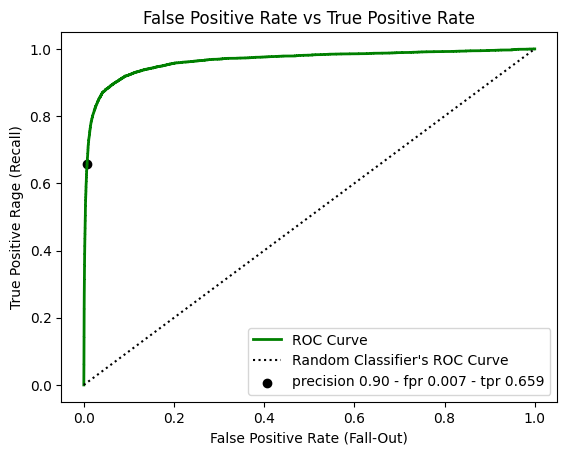

In [211]:
plt.plot(fpr, tpr, "g-", linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k:", label="Random Classifier's ROC Curve")
plt.scatter(
    fpr_90,
    tpr_90,
    c="black",
    label=f"precision {precision:.2f} - fpr {fpr_90:.3f} - tpr {tpr_90:.3f}",
)

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rage (Recall)')
plt.title('False Positive Rate vs True Positive Rate')
plt.legend()
plt.show()

One way to compare classifiers is to mesure the *area under the curve* (AUC). A perfect classifier will throught ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [168]:
roc_auc_score(y_train_5, y_scores)

0.9648211175804801

In [171]:
auc(recalls, precisions)

0.8516884753119622

It seems that the compute of *recall/precision* is lower than *fpr/tpr*. **As a rule of thumb, P/R curve is better whenever the positives class is rare or when you care more about the false positives than false negatives**. So for now, we will use *recall/precision* as we have a skeweed dataset, where the positive class is rare.

## SGD vs RandomForest

### SGD

In [172]:
sgd_clf = SGDClassifier()

y_scores_sgd = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1, verbose=10, method="decision_function"
)
y_scores_sgd

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished


array([  6359.49229328, -12423.61629485, -25264.4135085 , ...,
         5163.54246859, -11073.8297505 , -15612.4068507 ])

In [173]:
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(
    y_train_5, y_scores_sgd
)

In [174]:
precisions_sgd[:5]

array([0.09035   , 0.09035151, 0.09035301, 0.09035452, 0.09035602])

In [175]:
idx_precision_90_sgd = (precisions_sgd >= 0.9).argmax()
idx_precision_90_sgd

57070

In [176]:
precisions[idx_precision_90_sgd]

0.9368600682593856

In [177]:
recalls_sgd[:5]

array([1., 1., 1., 1., 1.])

In [178]:
recalls_sgd[idx_precision_90_sgd]

0.4864416159380188

In [179]:
thresholds_sgd[:5]

array([-109935.99554855, -107194.56335405, -104778.06915375,
       -104098.50421196, -102390.8118998 ])

In [180]:
thresholds_sgd[idx_precision_90_sgd]

6319.2220179009255

### Random Forest

In [184]:
forest_clf = RandomForestClassifier()

y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, n_jobs=-1, verbose=10, method="predict_proba"
)
y_probas_forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished


array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.  , 1.  ],
       [0.93, 0.07],
       [0.88, 0.12]])

The snd column contains the estimated probabilities for the positive class.

In [185]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 1.  , 0.07, 0.12])

In [186]:
from sklearn.metrics import precision_recall_curve

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

In [187]:
precisions_forest[:5]

array([0.09035   , 0.15528502, 0.21484917, 0.27371452, 0.3344238 ])

In [188]:
idx_precision_90_forest = (precisions_forest >= 0.9).argmax()
idx_precision_90_forest

24

In [189]:
recalls_forest[:5]

array([1.        , 1.        , 0.99981553, 0.99963106, 0.9994466 ])

In [190]:
recalls_forest[idx_precision_90_forest]

0.9730676996864047

In [191]:
thresholds_forest[:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

In [192]:
thresholds_forest[idx_precision_90_forest]

0.24

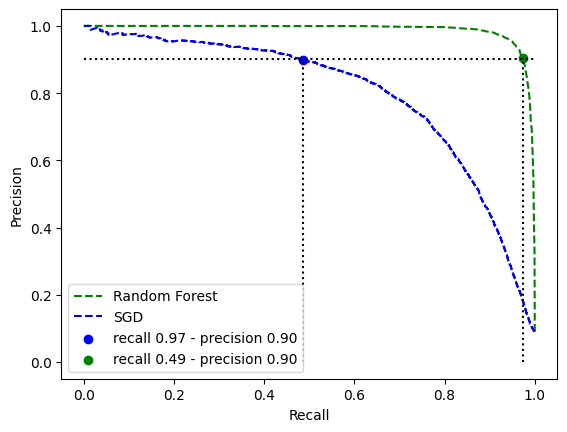

In [203]:
recall_forest = recalls_forest[idx_precision_90_forest]
precision_forest = precisions_forest[idx_precision_90_forest]
recall_sgd = recalls_sgd[idx_precision_90_sgd]
precision_sgd = precisions_sgd[idx_precision_90_sgd]


plt.plot(recalls_forest, precisions_forest, "g--", label="Random Forest")
plt.plot(recalls_sgd, precisions_sgd, "b--", label="SGD")
plt.hlines(
    np.mean(
        [
            precisions_sgd[idx_precision_90_sgd],
            precisions_forest[idx_precision_90_forest],
        ]
    ),
    0,
    1,
    "k",
    "dotted",
)
plt.vlines(
    recalls_sgd[idx_precision_90_sgd],
    0,
    precisions_sgd[idx_precision_90_sgd],
    "k",
    "dotted",
)
plt.vlines(
    recalls_forest[idx_precision_90_forest],
    0,
    precisions_forest[idx_precision_90_forest],
    "k",
    "dotted",
)
plt.scatter(
    recall_sgd, 
    precision_sgd, 
    c="b",
    label=f"recall {recall_forest:.2f} - precision {precision_forest:.2f}"
)
plt.scatter(
    recall_forest,
    precision_forest,
    c="g",
    label=f"recall {recall_sgd:.2f} - precision {precision_sgd:.2f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()
plt.show()

In [204]:
auc(recalls_sgd, precisions_sgd)

0.799819603616873

In [206]:
auc(recalls_forest, precisions_forest)

0.9888394473769377

The `auc` metric points out that in general RandomForest performs much better than the SGD no matter the treshold. The requirements asked to have a precision of 90%, both model can achive to this metric but RandomForest with the same precision has much more recall so more samples of 5 are detected.